In [1]:
#!pip install ngrok -q
#!pip install dash -q
#!pip install "dash[diskcache]" -q

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig, AutoConfig, StoppingCriteriaList, StoppingCriteria
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import itertools
import torch

In [3]:
# https://github.com/oobabooga/text-generation-webui/blob/2cf711f35ec8453d8af818be631cb60447e759e2/modules/callbacks.py#L12
class _SentinelTokenStoppingCriteria(StoppingCriteria):
    def __init__(self, sentinel_token_ids: list, starting_idx: int):
        StoppingCriteria.__init__(self)
        self.sentinel_token_ids = sentinel_token_ids
        self.starting_idx = starting_idx
        self.shortest = min([x.shape[-1] for x in sentinel_token_ids])

    def __call__(self, input_ids: torch.LongTensor, _scores: torch.FloatTensor) -> bool:
        for sample in input_ids:
            trimmed_sample = sample[self.starting_idx:]
            trimmed_len = trimmed_sample.shape[-1]
            if trimmed_len < self.shortest:
                continue

            for sentinel in self.sentinel_token_ids:
                sentinel_len = sentinel.shape[-1]
                if trimmed_len < sentinel_len:
                    continue

                window = trimmed_sample[-sentinel_len:]
                if torch.all(torch.eq(sentinel, window)):
                    return True

        return False
####

def generate_stopping_criteria(stopgen_tokens, input_len=0):
    return StoppingCriteriaList([
        _SentinelTokenStoppingCriteria(
            sentinel_token_ids = stopgen_tokens,
            starting_idx=input_len
        )
    ])


# CODE

In [4]:
#model_id = "microsoft/phi-1_5"
#model_id = "meta-llama/Llama-2-7b-hf"
model_id = "mistralai/Mistral-7B-v0.1"
torch.set_default_device("cpu")

In [ ]:
hf_key = ""
if model_id in ["meta-llama/Llama-2-7b-hf"]:
    hf_key = input("Hugging Face Key: ")
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, token=hf_key)
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, token=hf_key)
model_config = AutoConfig.from_pretrained(model_id, trust_remote_code=True, token=hf_key)
del hf_key

In [6]:
if model_id in ["microsoft/phi-1_5"]:
    stopgen_tokens = [
        torch.tensor([198, 198]),  # \n\n
        torch.tensor([628])        # \n\n
    ]
    prompt_structure = "Question: {prompt}\n\nAnswer:"
    exclude_token_offset = 3
    fix_characters = [("Ġ", "␣"), ("Ċ", "\n")]
elif model_id in ["meta-llama/Llama-2-7b-hf", "mistralai/Mistral-7B-v0.1"]:
    stopgen_tokens = [
        torch.tensor([1]),  # <s>
        torch.tensor([2])   # </s>
    ]
    prompt_structure = "{prompt}"
    exclude_token_offset = None
    fix_characters = [("<0x0A>", "\n")]

fix_characters += [("\n", "\\n")]

In [7]:
if tokenizer.eos_token_id and not tokenizer.pad_token_id:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [8]:
### ALTERATION ### Divided computation for attentions
### ALTERATION ###  Added function to compute attentions also for prompt

def pad_masked_attentions(attentions, max_len):
    """
    Attention in generative models are masked, we want to plot a heatmap so we must pad all attentions to the same size with 0.0 values
    """
    array_attentions = [np.array(att) for att in attentions]
    new_attentions = [np.concatenate([att, np.zeros([max_len - len(att)])]) for att in array_attentions]
    return np.array(new_attentions)

def compute_complete_padded_attentions(generated_output, layer, head):
    single_layer_attentions = []
    # Prompt tokens
    for single_layer_single_head in torch.squeeze(torch.select(generated_output.attentions[0][layer], 1, head)):
        single_layer_attentions.append(single_layer_single_head)
    # Response tokens
    for attentions_per_token in generated_output.attentions[1:]:
        # Take single layer
        single_layer = attentions_per_token[layer]
        # Take only one head
        single_layer_single_head = torch.select(single_layer, 1, head)
        single_layer_attentions.append(single_layer_single_head)
    # Squeeze dimensions to one a one-dimensional tensor
    pure_attentions = [s.squeeze() for s in single_layer_attentions]
    max_seq_len  = len(pure_attentions[-1])
    # Print last attention heatmap
    padded_attentions = pad_masked_attentions(pure_attentions, max_seq_len)
    return padded_attentions

def compute_batch_complete_padded_attentions(generated_output, heads):
    multi_layer_head_attentions = []
    for head in heads:
        multi_layer_attentions = []
        for layer in range(0, len(generated_output.attentions[0])):
            # Prompt tokens
            prompt_att = [
                torch.squeeze(single_head)
                for single_head in torch.squeeze(torch.select(generated_output.attentions[0][layer], 1, head))
            ]
            # Response tokens
            response_att = [
                torch.squeeze(torch.select(single_layer[layer], 1, head))
                for single_layer in generated_output.attentions[1:]
            ]
            # Pad and merge attentions
            multi_layer_attentions.append(pad_masked_attentions( 
                [att_token for att_token in prompt_att + response_att],
                len(response_att[-1])
            ))
        multi_layer_head_attentions.append(multi_layer_attentions)
    return multi_layer_head_attentions

def plot_attentions(generated_output, layer, head, generated_tokens, past_tokens):
    # Plot 
    data = compute_padded_attentions(generated_output, layer, head)
    fig, ax = plt.subplots(figsize = (12,5))
    im = ax.imshow(data)
    # Show all ticks and label them with the respective list entries
    ax.set_yticks(np.arange(len(generated_tokens)), labels=generated_tokens)
    ax.set_xticks(np.arange(len(past_tokens)), labels=past_tokens, fontsize=8)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    ax.set_title(f"Heatmap of attention layers: layer {layer} head {head}")
    fig.tight_layout()
    plt.show()

In [9]:
### ALTERATION ### Adapted functions to work outside model
### ALTERATION ### Added option to include hidden states for prompt and ending token in embed_hidden_states
def _apply_lm_head(model, hidden_states, weights, bias):
    """
    Function which takes as input the hidden states of the model and returns the prediction of the next token.
    Uses the language modeling head of input
    """
    pred_ids = []
    for token_layer in hidden_states:
        output = torch.matmul(token_layer.to(weights.device), weights) + bias
        token_id = output.argmax(dim=-1)
        pred_ids.append(token_id)
    return pred_ids
    
def embed_hidden_states(model, hidden_states, embedding="output", include_prompt=False, include_end=True, multirep=True, max_rep=10):
    if embedding not in ['input', 'output']:
        raise ValueError("Embedding not valid")

    end_idx = len(hidden_states) if include_end else len(hidden_states) - 1

    if embedding == 'output':
        weights = model.lm_head.weight.T
    elif embedding == 'input':
        weights = model.model.embed_tokens.weight.T

    bias = model.lm_head.bias
    if bias:
        reverse_weights = torch.add(weights.T, bias.unsqueeze(dim=1))
    else:
        bias = 0
        reverse_weights = weights.T 

    predictions = []
    # Prompt tokens
    if include_prompt:
        for token_states in torch.stack(hidden_states[0]).swapaxes(0, 2):
            if multirep:
                pred_ids = compute_multirep(model, token_states.swapaxes(0, 1), weights, bias, reverse_weights, max_rep=max_rep)
            else:
                pred_ids = [_apply_lm_head(model, token_states.swapaxes(0, 1), weights, bias)]
            predictions.append([[int(id) for id in idd] for idd in pred_ids])
    # Response tokens
    for token_states in hidden_states[1:end_idx]:
        if multirep:
            pred_ids = compute_multirep(model, token_states, weights, bias, reverse_weights, max_rep=max_rep)
        else:
            pred_ids = [_apply_lm_head(model, token_states, weights, bias)]
        predictions.append([[int(id) for id in idd] for idd in pred_ids])
    return predictions

def compute_multirep(model, hidden_states, weights, bias, reverse_weights, max_rep=5):
    pred_ids = []
    #pred_norms = []
    for i, hs in enumerate(hidden_states):
        tokens = []
        norms = []
        token_emb = hs.squeeze()
        for i in range(0, max_rep):
            # Compute token and embedding norm
            logits = torch.matmul(token_emb, weights) + bias
            token_id = torch.argmax(logits)
            norm = torch.norm(token_emb) 
            # Stop prematurely if norm is too small or if norm is bigger than previous one
            if norm <= 0.01 or (len(norms) > 0 and norm >= norms[-1]):
                break
            # Do not add repreated tokens
            if token_id not in tokens:
                tokens.append(token_id)
            norms.append(norm)
            # Compute next embedding by subtracting the closest embedding to the current embedding
            closest_emb = reverse_weights[token_id]
            token_emb = token_emb - closest_emb
        pred_ids.append(tokens)
        #pred_norms.append(norms)
    return pred_ids#, pred_norms

def test_multirep(model, input, embedding, token=1):
    if embedding == 'output':
        weights = model.lm_head.weight.T
    elif embedding == 'input':
        weights = model.model.embed_tokens.weight.T

    bias = model.lm_head.bias
    if bias:
        reverse_weights = torch.add(weights.T, bias.unsqueeze(dim=1))
    else:
        bias = 0
        reverse_weights = weights.T 
    inputs = tokenizer("Hi, how are you", return_tensors="pt")
    gen_config = GenerationConfig(
        pad_token_id=tokenizer.eos_token_id if tokenizer.eos_token_id else None,
        output_attentions=True, output_hidden_states=True, return_dict_in_generate=True
    )
    gen_output = model.generate(inputs.input_ids, generation_config=gen_config, max_new_tokens=5)
    print(tokenizer.decode(gen_output.sequences.squeeze()))
    a,aa = compute_multirep(model, gen_output.hidden_states[1], weights, bias, reverse_weights)
    return [[(tokenizer.decode(c), cc.detach().numpy().tolist()) for c,cc in zip(b,bb)] for b,bb in zip(a,aa)]


In [10]:
def fix_dataframe_characters(df, replacements, multirep=False, columns=False):
    for old, new in replacements:
        df = df.map(lambda x: [i.replace(old, new) for i in x] if multirep else x.replace(old, new))
    if columns:
        for old, new in replacements:
            df.columns = df.columns.str.replace(old, new)
    return df

In [11]:
def compute_edge_precache(nodes, edges, pedges, heads):
    return {
        (x,y):  { 
            head: {
                "edges": traces,
                "color_nodes": {
                    emb: compute_color_nodes(emb_nodes, traces + pedges[head], x, y) 
                    for emb, emb_nodes in nodes.items()
                }
            } for head in heads if (traces := compute_add_traces(edges[head], x, y)) or True
        }
        for x,y in [(x,y) for node_coords in [zip(node_batch.x, node_batch.y) for node_batch in list(nodes.values())[0]] for x,y in node_coords]
    }

def access_edge_cache(cache, x, y, attention_head, embedding, color_scale):
    add_traces = cache[(x,y)][attention_head]["edges"]
    add_color_nodes = cache[(x,y)][attention_head]["color_nodes"][embedding]
    add_color_nodes = [apply_color(node, trace, color_scale) for node, trace in add_color_nodes]
    return add_traces, add_color_nodes

def compute_add_traces(edges, x, y):
    return [
        el for el in edges if (
            el.customdata[0]["P1"]["x"] == x and el.customdata[0]["P1"]["y"] == y
        ) or (
            el.customdata[0]["P2"]["x"] == x and el.customdata[0]["P2"]["y"] == y
        )
    ]

def compute_color_nodes(nodes, add_traces, x, y):
    return [
        (node, trace)
        for trace in add_traces for node in filter(lambda n: n.y[0] == y - 1 and n.x[0] <= x, nodes) 
        if trace.customdata[0]["P1"]["x"] in node.x and trace.customdata[0]["P1"]["y"] in node.y and
            trace.customdata[0]["P2"]["x"] == x and trace.customdata[0]["P2"]["y"] == y
    ]

def apply_color(node, trace, color_scale):
    node["marker"]["color"] = pc.sample_colorscale(color_scale, float(trace.text))
    return node

In [12]:
def model_generate(model, tokenizer, prompt, max_extra_length, config, min_stop_length, stopping_tokens):
    inputs = tokenizer(prompt, return_tensors="pt")
    input_len = len(inputs.input_ids.squeeze().tolist())
    max_len = input_len + max_extra_length
    
    gen_config = config
    stopping_criteria = generate_stopping_criteria(stopping_tokens, input_len + min_stop_length)
    
    generated_output = model.generate(inputs.input_ids, generation_config=gen_config, max_length=max_len, stopping_criteria=stopping_criteria)
    outputs = generated_output.sequences.squeeze()
    text_output = tokenizer.decode(generated_output.sequences.squeeze()[input_len:])
    
    all_tokens = tokenizer.convert_ids_to_tokens(generated_output.sequences[0])
    input_tokens = all_tokens[0:input_len]
    generated_tokens = all_tokens[input_len:]
    
    return text_output, generated_output, {"in": input_tokens, "gen": generated_tokens}

def create_hidden_states_df(model, tokenizer, generated_output, gen_tokens, embedding, include_prompt, fix_characters, multirep=False):
    predictions = embed_hidden_states(model, generated_output.hidden_states, embedding, include_prompt=include_prompt, multirep=multirep, max_rep=5)
    rows = [[tokenizer.convert_ids_to_tokens(pred) for pred in pred_list] for pred_list in predictions]
    rows = rows if multirep else np.squeeze(rows)
    if embedding == "input":
        cols = gen_tokens["in"] + gen_tokens["gen"][:-1]
    else:
        cols = gen_tokens["in"][1:] + gen_tokens["gen"]
    df = pd.DataFrame(rows).T.sort_index(ascending=False).rename(columns={n: col for n, col in enumerate(cols)})
    df = fix_dataframe_characters(df, fix_characters, multirep=multirep, columns=True)
    return df

def create_attention_visualization(dfs, generated_output, exclude, heads, max_heads, compute_precache=True, multirep=False):
    figure, nodes, edges = create_transformer_plot(dfs, generated_output, exclude, heads=heads, max_heads=max_heads, multirep=multirep)
    edges, permanent_edges = edges
    permanent_traces = {head: {"edges": permanent_edges[head]} for head in heads}
    edge_precache = compute_edge_precache(nodes, edges, permanent_edges, heads) if compute_precache else None
    return figure, {"nodes": nodes, "edges": edges, "perm": permanent_traces}, edge_precache

In [13]:
def cumulative_attention_traces_separate(
    df, attentions,         # Dataframe and attentions to access labels and attention weights
    row, index, el_index,   # Dataframe is indexed by index and row, while el_index references the index for sankey visualization
    base,                   # Base attention value of parent
    labels,                 # Current set of labels for sankey visualization
    n_el,                   # Current number of nodes inside cumulative sankey labels list
    rowlimit,               # Depth limit
):
    new_labels = []
    label_indexes = []
    val = []
    # Iterate over all elements of the next row
    for i, label in enumerate(df.iloc[row+1].tolist()):
        # Calculate current value of node by weighting its attention value for the parent's weight
        v = base * attentions[row][index][i]
        if v > 0:
            new_labels.append(label)
            label_indexes.append(i)
            val.append(v)
    # Generate lists for sankey traces, composed by source/target nodes and respective values
    under = [i for i in range(n_el, n_el + len(new_labels))]
    over = [el_index] * len(new_labels)
    # TODO: copy necessary?     
    new_under = under.copy()
    new_val = val.copy()
    # If depth limit is reached, stop recurring
    if row < rowlimit:
        # Call itself on all the new nodes (NOTE: zip only iterates over the smallest list size)
        for u,v,idx in zip(under, val, label_indexes):
            nex_under, nex_over, nex_val, nex_labels = cumulative_attention_traces_separate(df, attentions, row+1, idx, u, v, new_labels, n_el + len(new_labels), rowlimit)
            # Update sankey trace lists and sankey labels list with children's results
            new_under += nex_under
            over += nex_over
            new_val += nex_val
            new_labels += nex_labels
    # Only executed at topmost level
    if el_index == 0:
        # Complete sankey labels list with starting label
        new_labels = labels + new_labels
        
    return new_under, over, new_val, new_labels

def propagate_carry(elmap, carry, anchors):
    for k,v in elmap.items():
        if v["anchor"][0] in anchors:
            elmap[k] |= {"carry": v["carry"] + carry}
            # If the current element has children, propagates carry to them
            if len(v["anchor"]) > 1:
                # Recur while removing joint set of anchors to avoid duplicating carries
                propagate_carry(elmap, carry, [an for an in v["anchor"] if an not in anchors])
    return elmap

def cumulative_attention_traces_join(
    df, attentions,         # Dataframe and attentions to access labels and attention weights
    row, index, el_index,   # Dataframe is indexed by index and row, while el_index references the index for sankey visualization
    base,                   # Base attention value of parent
    labels,                 # Current set of labels for sankey visualization
    elmap,                  # Reference for duplicate nodes as a dictionary indexed with (row, index) and containing a dictionary composed of
                            #  a list of anchors (sankey indexes for the node itself and its immediate children) and a float representing its carry
    rowlimit,               # Depth limit
):
    new_labels = []
    new_label_indexes = []
    reused_labels = []
    reused_values = []
    val = []
    new_elmap = elmap.copy() # TODO: copy necessary?
    # Iterate over all elements of the next row
    for i, label in enumerate(df.iloc[row+1].tolist()):
        # Calculate current value of node by weighting its attention value for the parent's weight
        v = base * attentions[row][index][i]
        if v > 0:
            # If node is already present store its information and propagate the current value to the node and its children
            if (row+1, i) in elmap:
                anchors = elmap[(row+1, i)]["anchor"]
                new_elmap = propagate_carry(new_elmap, v, anchors)
                reused_labels.append(anchors[0])
                reused_values.append(v)
            # If the node is new create a new entry in the element map with a new sankey index and 0 carry
            else:
                new_elmap[(row+1, i)] = {"anchor": [len(new_elmap.keys())], "carry": 0}
                new_labels.append(label)
                new_label_indexes.append(i)
                val.append(v)
    # Generate lists for sankey traces, composed by source/target nodes and respective values
    under = [i for i in range(len(elmap.keys()), len(new_elmap.keys()))] + reused_labels
    over = [el_index] * (len(new_labels) + len(reused_labels))
    val = val + reused_values
    # Update element map by adding children relations to the parent node
    for k,v in new_elmap.items():
        if v["anchor"][0] == el_index:
            v["anchor"].extend(under)
    # TODO: copy necessary?       
    new_under = under.copy()
    new_val = val.copy()
    # If depth limit is reached, stop recurring
    if row < rowlimit:
        # Call itself on all the new nodes (NOTE: zip only iterates over the smallest list size)
        for u,v,idx in zip(under, val, new_label_indexes):
            nex_under, nex_over, nex_val, nex_labels, new_elmap = cumulative_attention_traces_join(df, attentions, row+1, idx, u, v, new_labels, new_elmap, rowlimit)
            # Update elements map, sankey trace lists and sankey labels list with children's results
            new_elmap = new_elmap
            new_under += nex_under
            over += nex_over
            new_val += nex_val
            new_labels += nex_labels
    # Only executed at topmost level
    if el_index == 0:
        # Complete sankey labels list with starting label
        new_labels = labels + new_labels
        # Compute carries from reused labels
        np_over = np.array(over)
        np_under = np.array(new_under)
        for el in dict(sorted(new_elmap.items(), key=lambda d: d[0])).values():
            el_idx = el["anchor"][0]
            carry = el["carry"]
            if carry > 0:
                carry_idxs = np.where(np_over == el_idx)[0]
                agg_idxs = np.where(np_under == el_idx)[0]
                if carry_idxs.any():
                    n = sum([new_val[agg_idx] for agg_idx in agg_idxs])
                    m = sum([new_val[carry_idx] for carry_idx in carry_idxs])
                    for carry_idx in carry_idxs:
                        new_val[carry_idx] = (new_val[carry_idx] * n) / m
                    
    return new_under, over, new_val, new_labels, new_elmap

In [14]:
prompt = "Beauty is in the eye of the"
gen_config = GenerationConfig(
    pad_token_id=tokenizer.eos_token_id if tokenizer.eos_token_id else None,
    output_attentions=True, output_hidden_states=True, return_dict_in_generate=True
)
text_output, generated_output, gen_tokens = model_generate(
    model, tokenizer, prompt, 
    max_extra_length=10, 
    config=gen_config, 
    min_stop_length=1, stopping_tokens=stopgen_tokens
)   
dfs = {}
for emb in ["input", "output"]:
    dfs[emb] = create_hidden_states_df(
        model, tokenizer, generated_output, gen_tokens, emb, 
        include_prompt=True, fix_characters=fix_characters,
        multirep=True,
    )
attentions = compute_batch_complete_padded_attentions(generated_output, range(0, 32))

MistralModel is using MistralSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


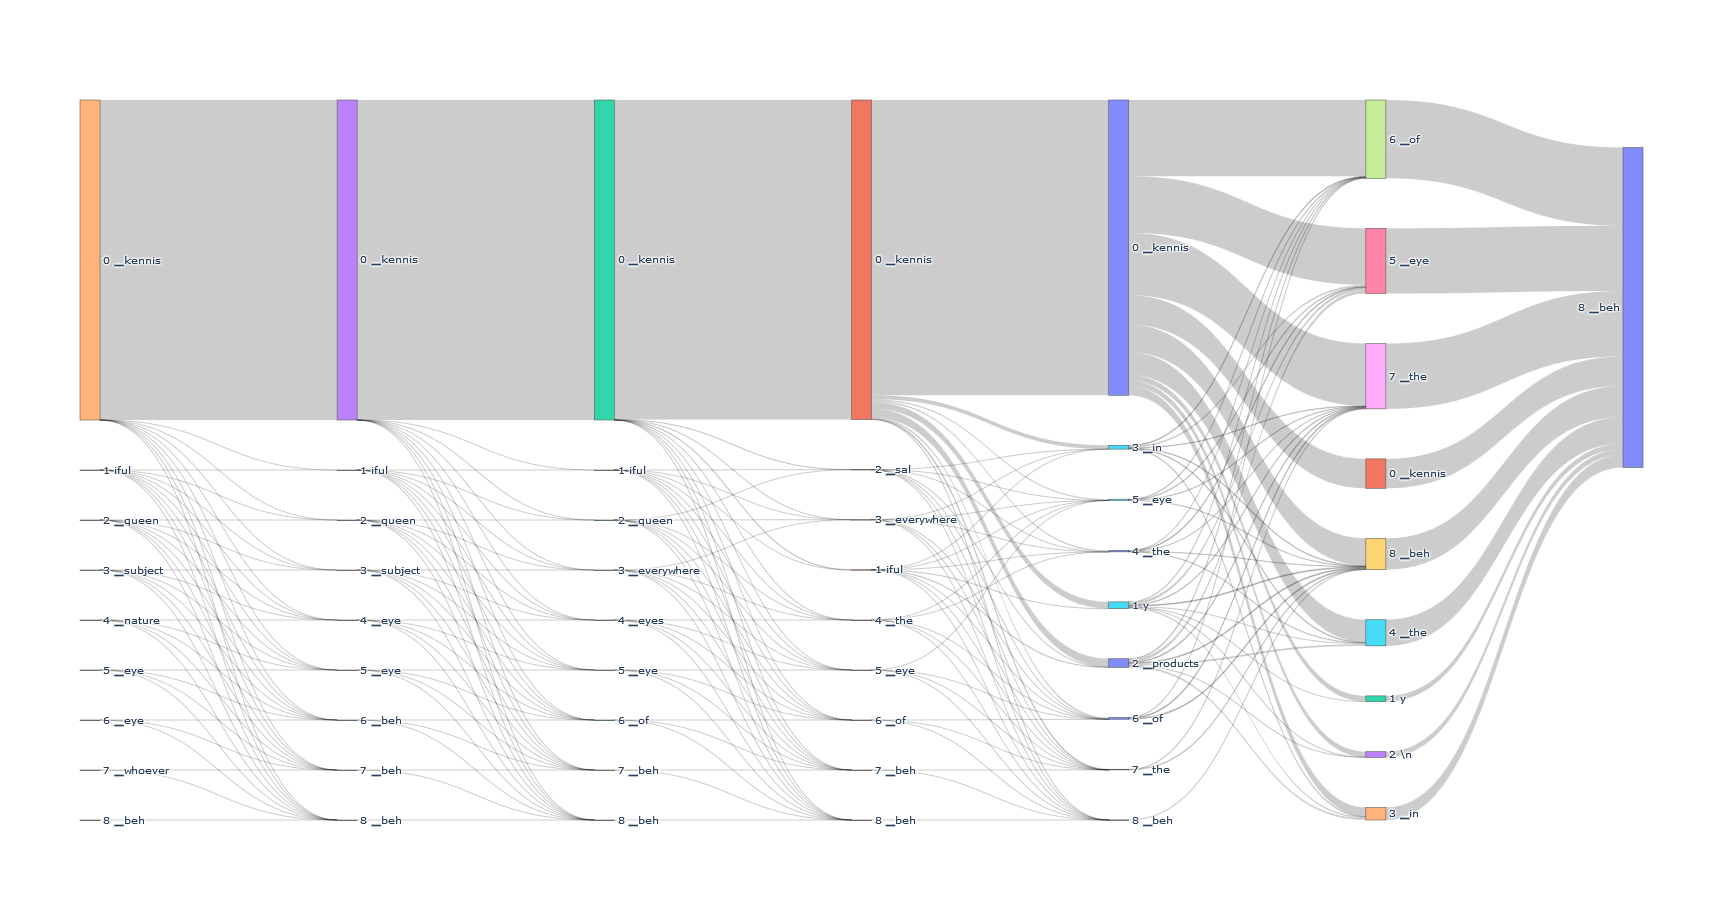

In [29]:
df = dfs["output"]
att = attentions[-1]
row_index = 0
token_index = 8
token_label = df.iloc[row_index].iloc[token_index]
rowlimit = 5
multirep = True

#un, ov, vl, lab = cumulative_attention_traces_separate(
#    dfs["input"], attentions[-1], 
#    row_index, token_index, 0, 
#    1.0, 
#    [token_label],
#    1,
#    rowlimit
#)
un, ov, vl, lab, elmap = cumulative_attention_traces_join(
    df, attentions[-1], 
    row_index, token_index, 0, 
    1.0, 
    [token_label], 
    {(row_index, token_index): {"anchor":[0], "carry":0}},
    rowlimit
)

if multirep:
    multirefs = lab
    lab = [l[0] for l in lab]
if elmap:
    lab = [f"{k[1]} {lab[v['anchor'][0]]}" for k,v in elmap.items()]
else:
    lab = [f"{i} {l}" for i,l in enumerate(lab)]

fig = go.Figure(go.Sankey(
    orientation = "h",
    arrangement="snap",
    valueformat=".5r",
    node=dict(
        customdata=multirefs,
        hovertemplate='%{customdata} - Value: %{value}<extra></extra>',
        align="left",
        label=lab,
        pad=50
    ),
    link=dict(
       source=un,
       target=ov,
       value=vl
    )
))
fig.update_layout(font_size=10, width=900, height=900)

fig.show()

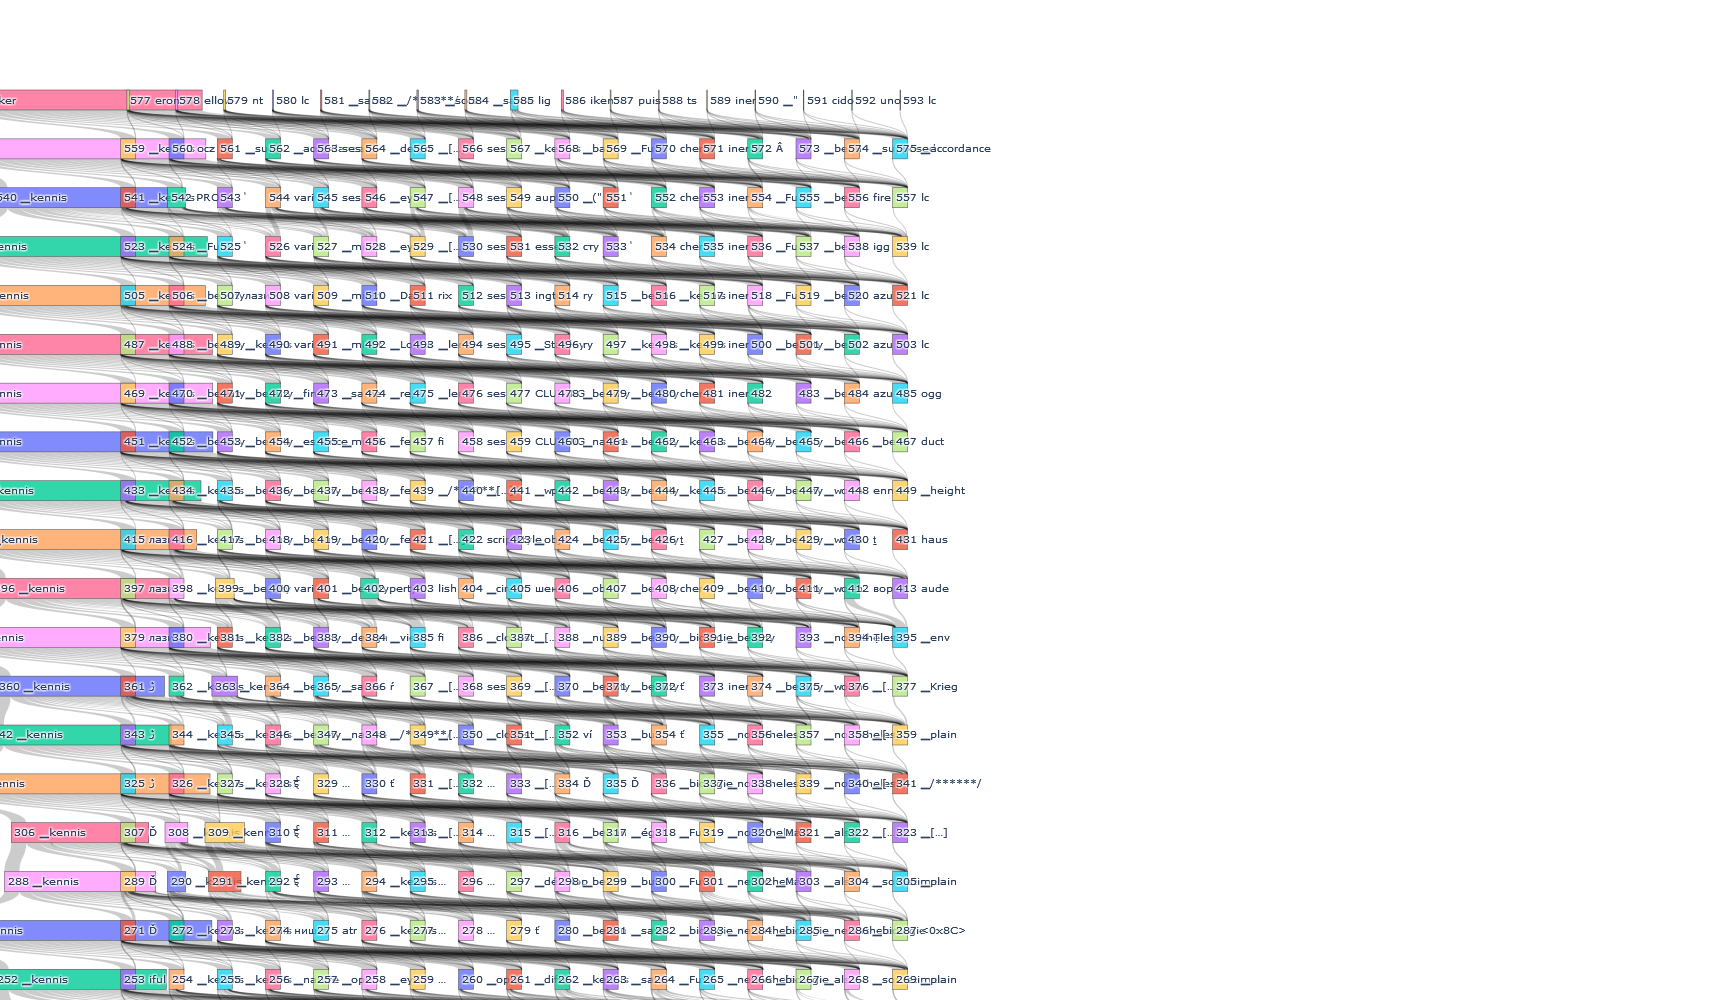

In [33]:
n_tok = len(dfs["output"].columns)

attentions = compute_batch_complete_padded_attentions(generated_output, range(0, 32))

# for key, df in dfs.items():        
nodexs = []
nodeys = []
labels = []
# Cycle through every layer of the model, gathering all blocks as nodes
for idx, row in dfs["output"].iterrows():
    # Generate coordinates for nodes
    xs = [i for i in range(len(row))]
    ys = [idx] * len(row)

    nodexs.append(xs)
    nodeys.append(ys)

    for x, y in zip(xs, ys):
        labels.append(row.iloc[x])

s = np.repeat([i for i in range(0, len(labels) - n_tok)], n_tok).astype(int).tolist()
t = np.array([[j for j in range(i, i + n_tok)] * n_tok for i in range(n_tok, len(labels), n_tok)]).flatten().astype(int).tolist()
v = np.array([[attentions[-1][i][j][::-1] for j in range(0, n_tok)][::-1] for i in reversed(range(0, 32))]).flatten()[::-1].astype(float).tolist()
s = [el_s for el_s, el_v in zip(s, v) if el_v > 0]
t = [el_t for el_t, el_v in zip(t, v) if el_v > 0]
v = [el_v for el_v in v if el_v > 0]

#nodexs = np.array(nodexs).flatten() 
#nodexs = (nodexs / nodexs.max()) * 0.1 + 0.0000001
#nodeys = np.array(nodeys).flatten()
#nodeys = (nodeys / nodeys.max()) * 3 + 0.0000001

# Vertical
#fig = go.Figure(go.Sankey(
#    orientation = "v",
#    arrangement='fixed',
#    valueformat=".5r",
#    node=dict(
#        align="left",
#        label=[f"{i} {l}" for i,l in enumerate(labels)],
#        y=nodexs,
#        x=nodeys[::-1],
#        pad=50
#    ),
#    link=dict(
#       source=s,
#       target=t,
#       value=v
#    )
#))
#fig.update_layout(font_size=10, width=1000, height=2700)

y_offset = 0

nodexs = np.array(nodexs).flatten() 
nodexs = (nodexs / nodexs.max()) + 0.0000001
nodeys = np.array(nodeys).flatten()
nodeys = (nodeys / nodeys.max() - y_offset) + 0.0000001

if multirep:
    multirefs = labels
    labels = [l[0] for l in labels]
    labels = [f"{i} {l}" for i,l in enumerate(labels)]

fig = go.Figure(go.Sankey(
    orientation = "h",
    arrangement="fixed",
    valueformat=".5r",
    node=dict(
        customdata=multirefs,
        hovertemplate='%{customdata} - Value: %{value}<extra></extra>',
        align="left",
        label=labels,
        y=nodexs,
        x=nodeys,
        pad=80
    ),
    link=dict(
       source=t,
       target=s,
       value=v
    )
))
fig.update_layout(font_size=10, width=4000, height=1000)

fig.show()